# Capstone Project - Sentimental Analysis on the Singapore Stock Market

### Library

In [1]:
import numpy as np
import pandas as pd
import os
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
# from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import keras
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
import importlib
import pickle

/var/folders/tg/k93_32z969551218v1lzn_4w0000gn/T/ipykernel_6187/3138673216.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yvonnepeh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2024-02-24 23:47:24.588730: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import functions as fn, sentiment_analysis as sa, model

### Import and Data 

In [4]:
'''
Stocks are downloaded from yahoo finance from Jan 2015 to Dec 2019 for analysis 
which are in line with the period of the sentiment analysis available (later part)
The function returns the merged data and the individual stocks. 
'''
data, msft, aapl, goog = fn.read_process_stock()

In [5]:
data.head(2)

,Date,Open_aapl,High_aapl,Low_aapl,Close_aapl,Adj Close_aapl,Volume_aapl,Open_msft,High_msft,Low_msft,Close_msft,Adj Close_msft,Volume_msft,Open_goog,High_goog,Low_goog,Close_goog,Adj Close_goog,Volume_goog
0,2015-01-02,27.8475,27.860001,26.837500,27.3325,24.466450,212818400,46.660000,47.419998,46.540001,46.759998,40.452747,27913900,26.378078,26.49077,26.133251,26.168653,26.168653,28951268
1,2015-01-05,27.0725,27.162500,26.352501,26.5625,23.777189,257142000,46.369999,46.730000,46.250000,46.330002,40.080730,39673900,26.091366,26.14472,25.582764,25.623152,25.623152,41196796


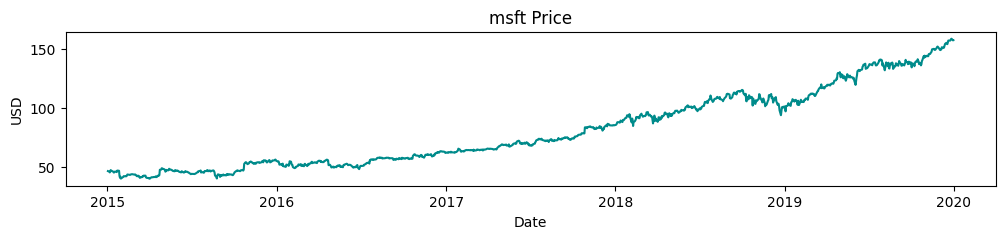

In [6]:
fn.plot_ts(data, 'msft', 'USD')

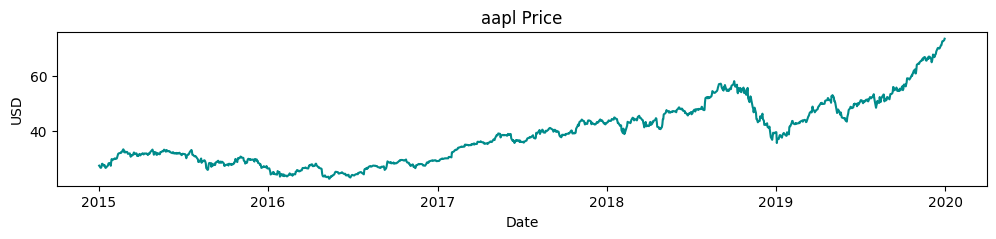

In [7]:
fn.plot_ts(data, 'aapl', 'USD')

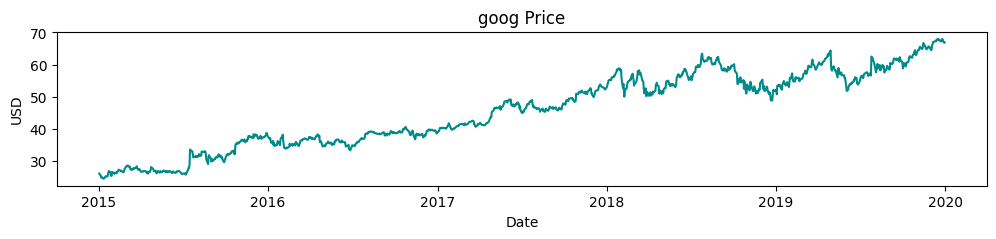

In [8]:
fn.plot_ts(data, 'goog', 'USD')

## Prepare technical indicator features

In order to help the model understand the trend of the training data better and give better predictions, technical indicators listed in the following are added. 
- Moving averages (MA7 and MA20)
- Bollinger bands (lower and upper)
- MACD: subtracting the 26-period exponential moving average (EMA) from the 12-period EMA

,Date,Open_goog,High_goog,Low_goog,Close_goog,Adj Close_goog,Volume_goog,MA7,MA20,MACD,20SD,upper_band,lower_band
0,2015-02-02,26.513706,26.577032,25.856510,26.351652,26.351652,56996054,26.195580,25.55990,-0.163930,0.735827,27.031555,24.088245
1,2015-02-03,26.327717,26.596977,26.091366,26.389547,26.389547,40773638,26.119289,25.59822,-0.167833,0.758889,27.115999,24.080442


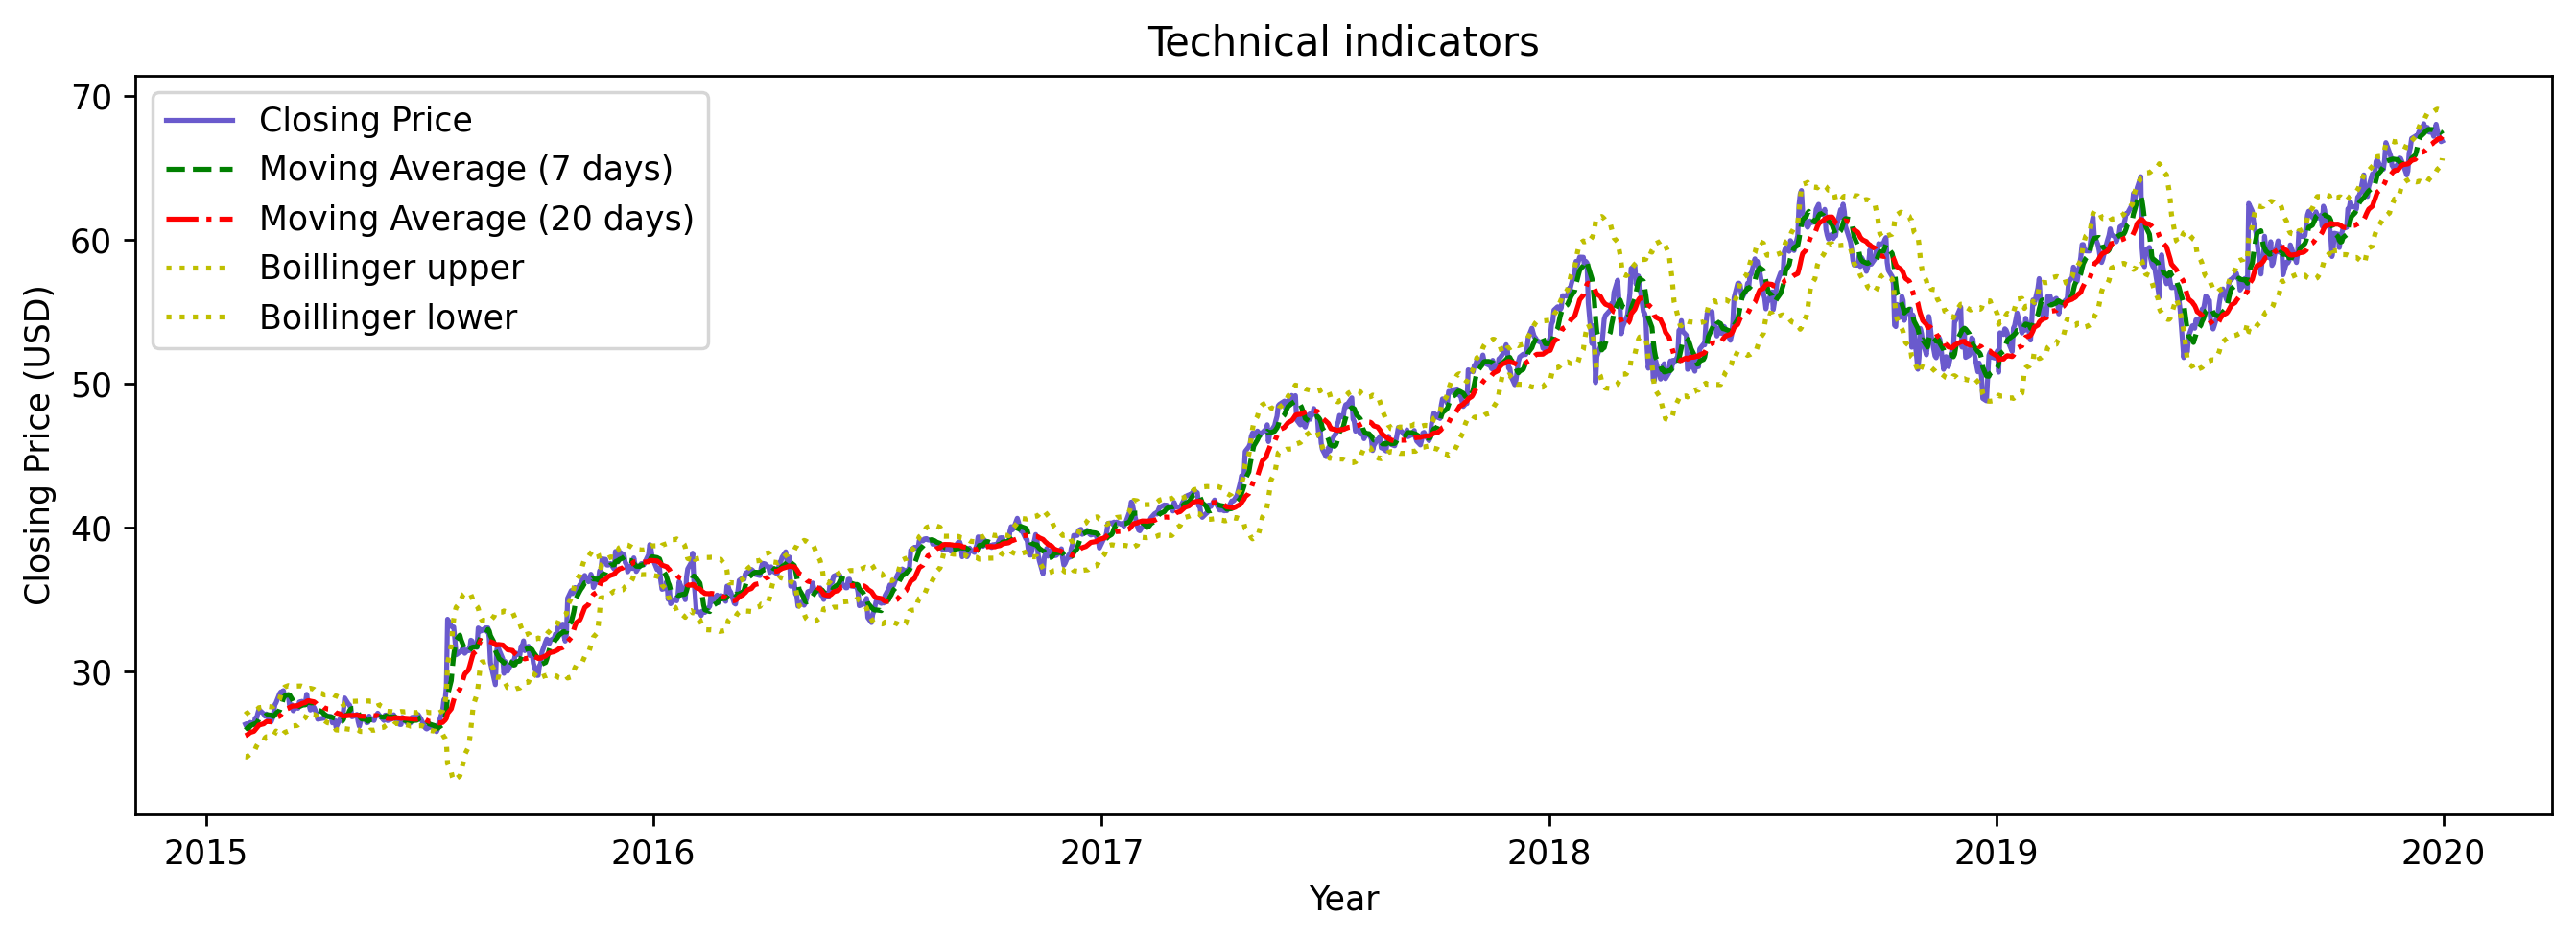

In [9]:
df_goog = fn.prep_stock_with_technical_analysis(goog, 'goog')

,Date,Open_msft,High_msft,Low_msft,Close_msft,Adj Close_msft,Volume_msft,MA7,MA20,MACD,20SD,upper_band,lower_band
0,2015-02-02,40.590000,41.369999,40.230000,41.279999,35.711926,50352500,43.104285,45.2400,0.777857,2.307811,49.855621,40.624378
1,2015-02-03,41.630001,41.930000,41.049999,41.599998,35.988750,52082400,42.307142,45.0035,0.837263,2.429389,49.862277,40.144722


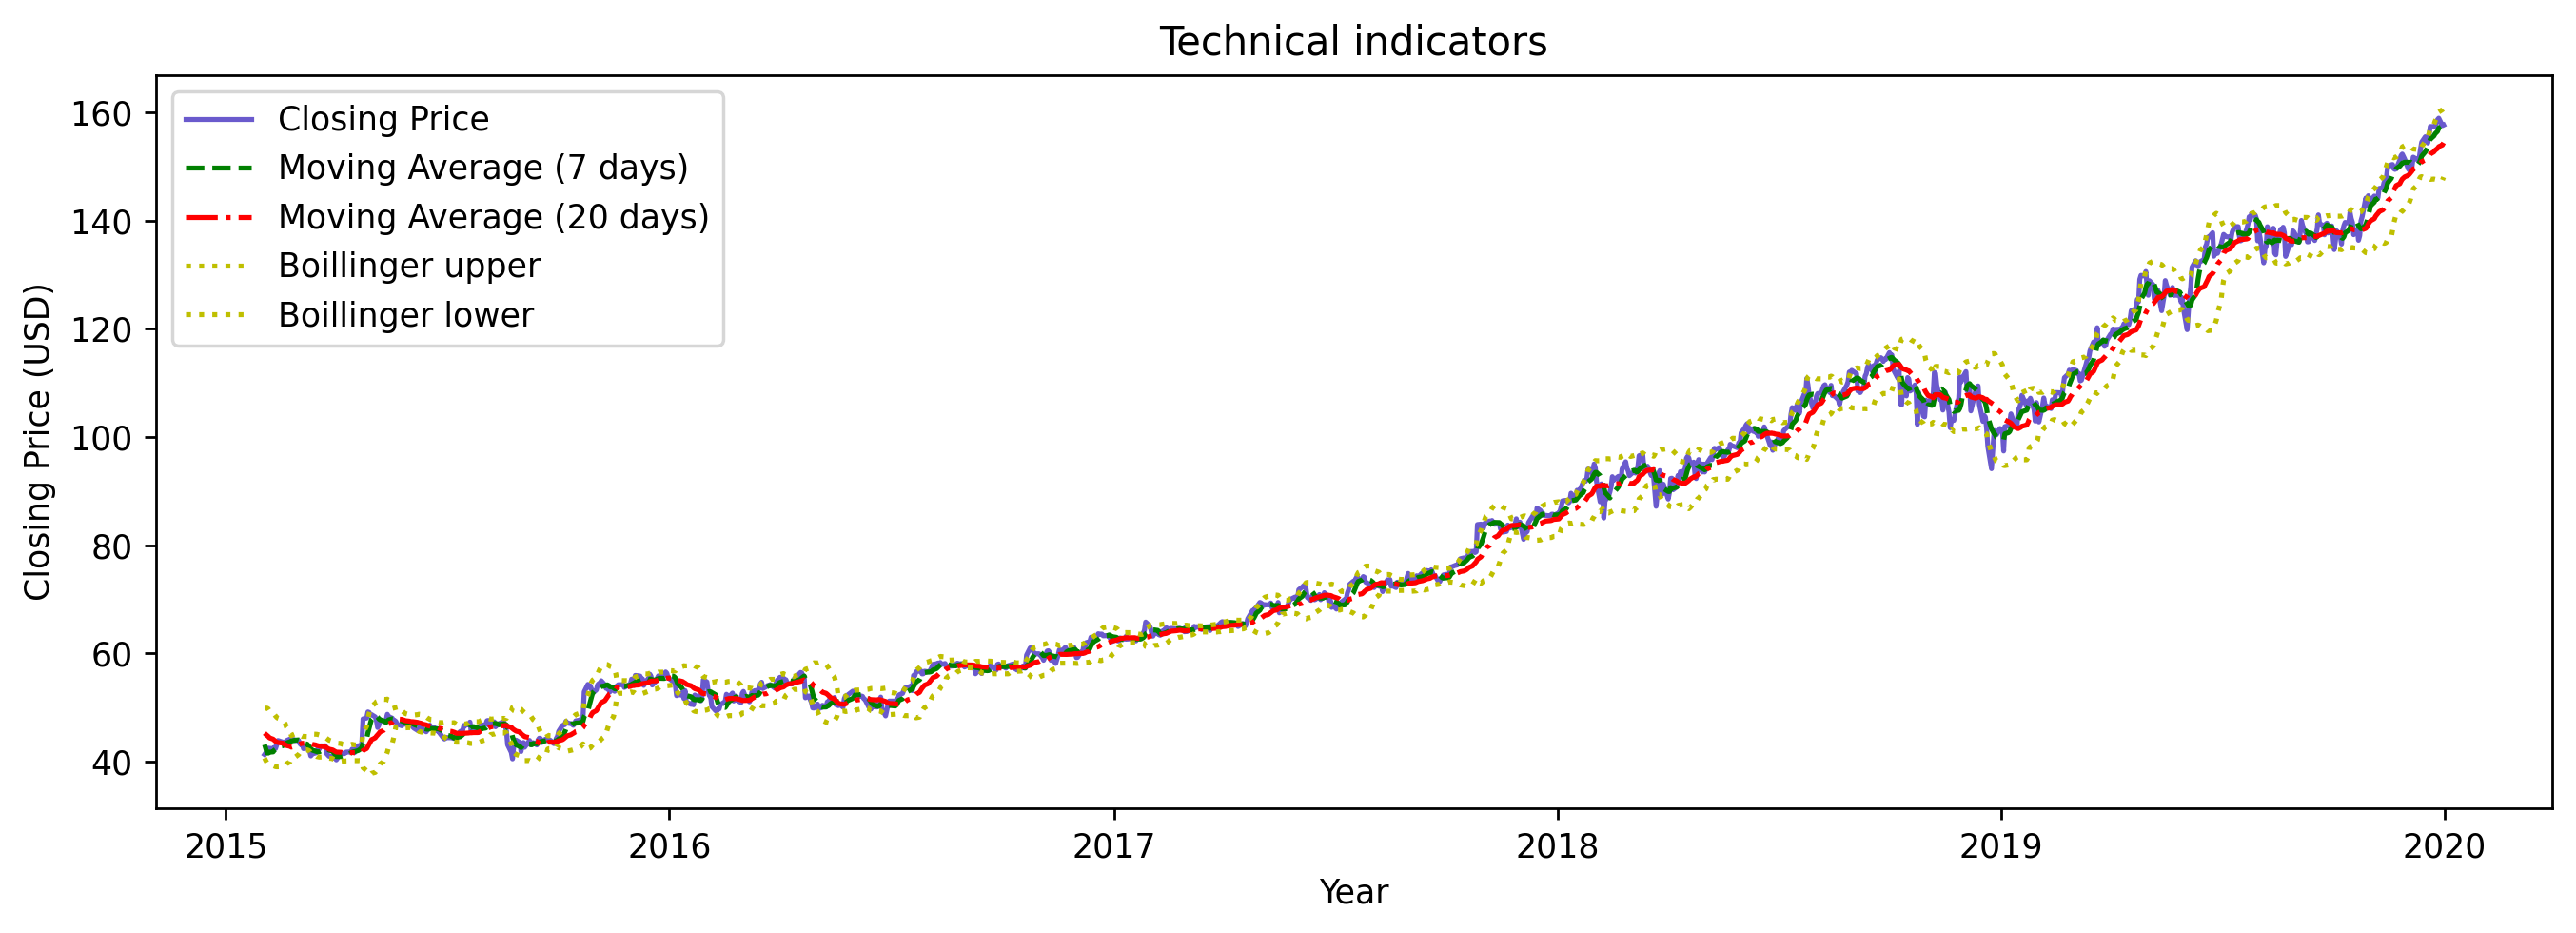

In [10]:
df_msft = fn.prep_stock_with_technical_analysis(msft, 'msft')

,Date,Open_aapl,High_aapl,Low_aapl,Close_aapl,Adj Close_aapl,Volume_aapl,MA7,MA20,MACD,20SD,upper_band,lower_band
0,2015-02-02,29.512501,29.792500,29.0200,29.657499,26.547651,250956400,28.757857,27.776625,-0.439995,0.998454,29.773533,25.779717
1,2015-02-03,29.625000,29.772499,29.4025,29.662500,26.552130,207662800,28.960357,27.931625,-0.464846,1.039819,30.011262,25.851988


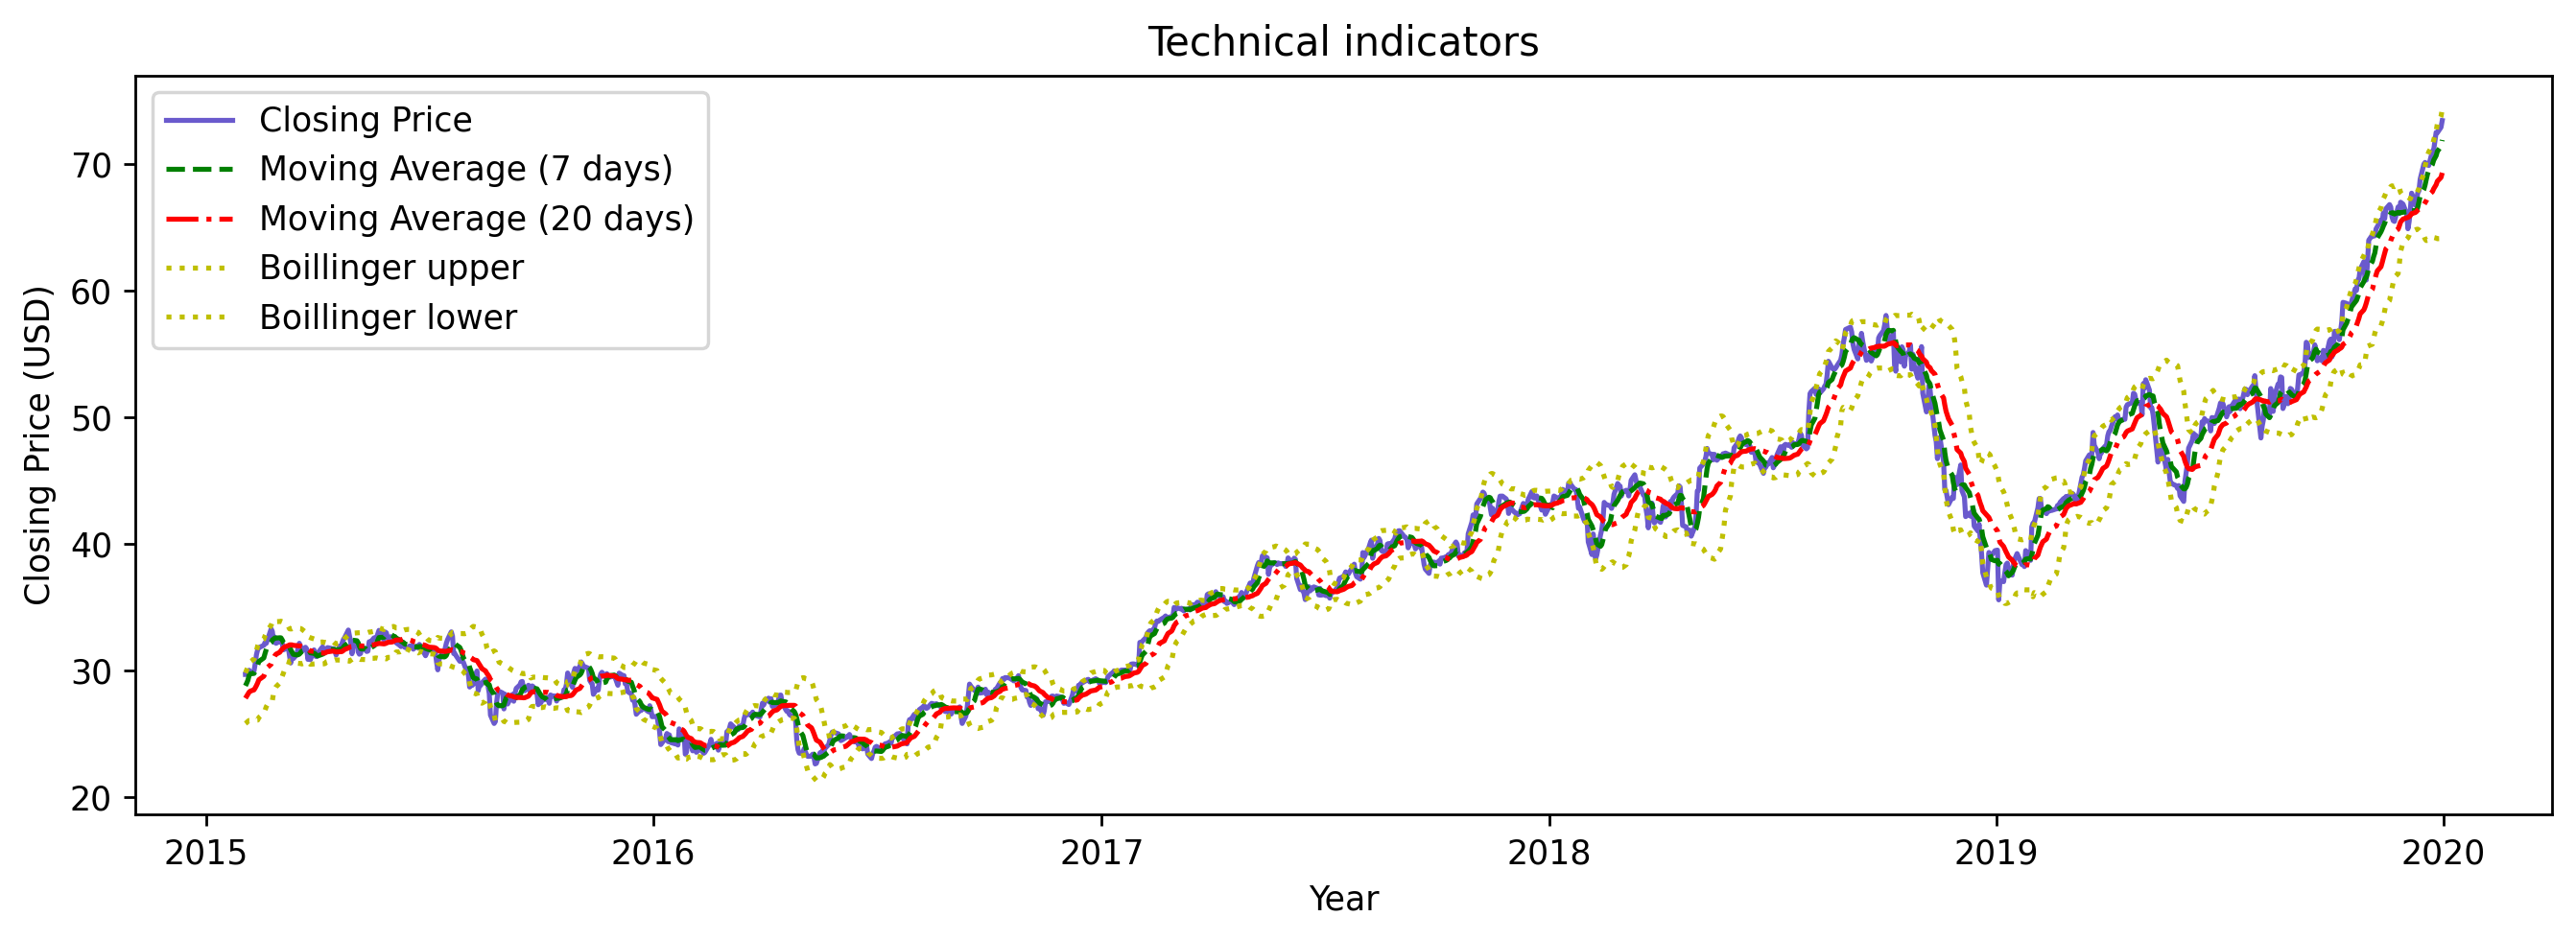

In [11]:
df_aapl = fn.prep_stock_with_technical_analysis(aapl, 'aapl')

## Prepare Sentiment Analysis (SA)

Dataset: https://www.kaggle.com/datasets/omermetinn/tweets-about-the-top-companies-from-2015-to-2020/data

In [12]:
%cd data

/Users/yvonnepeh/Downloads/proj/data


/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [13]:
tweet_old = pd.read_csv('Tweet.csv',engine='python',encoding='utf-8',on_bad_lines='warn')
coy_tweet = pd.read_csv('Company_Tweet.csv',engine='python',encoding='utf-8',on_bad_lines='warn')

In [14]:
tweets = sa.process_sa_data(tweet_old, coy_tweet)

There are 3717964 tweet in total.
Data Read: 


,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0


,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL


After merging: 


,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,date,ticker_symbol
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,2015-01-01,AAPL
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0,2015-01-01,AAPL


In [15]:
tweets.body[100]

'Facebook, Apple, And Microsoft ganging up on Google - Business Insider http://ow.ly/GDeSt $FB, $AAPL, $GOOG, $MSFT #InvestWall'

In [16]:
sia = SentimentIntensityAnalyzer()

print('Tesla misses quarterly earnings, analyst calls downgrade, sell now')
print(sia.polarity_scores('Tesla misses quarterly earnings, analyst calls downgrade, sell now'))

Tesla misses quarterly earnings, analyst calls downgrade, sell now
{'neg': 0.192, 'neu': 0.808, 'pos': 0.0, 'compound': -0.2263}


In [17]:
print('Google earnings is not looking that bad, analyst recommends buy')
sia.polarity_scores('Google earnings is not looking that bad, analyst recommends buy')

Google earnings is not looking that bad, analyst recommends buy


{'neg': 0.0, 'neu': 0.627, 'pos': 0.373, 'compound': 0.5789}

### Augment Vocabulary for Stocks to Improve SA
We can improve the sentiment analysis scores by augmenting vocabulary meant for stock purpose. \
Example is telling VADER that positive words include 'underpriced, bullish, high profit etc.'.

In [18]:
positive_words='high Outstanding Record Growth Potential Opportunity Bullish trend moon rocket \
Promising Profitable Win Winner Earnings Breakthrough buy bull long \
support undervalued underpriced cheap upward rising hold breakout call \
beat support buying holding bull profit Strong Valuable Success'
negative_words='resistance squeeze cover seller Risk Loss Decline Bearish Weak Declining \
Uncertain Troubling Unstable Volatile Slump Disaster Plunge sell bear Downturn Struggle \
bubble bearish short overvalued overbought overpriced expensive downward falling sold sell low put miss'

dictOfpos = { i : 4 for i in positive_words.split(" ") }
dictOfneg = { i : -4 for i in negative_words.split(" ")  }
Financial_Lexicon = {**dictOfpos, **dictOfneg}

sia.lexicon.update(Financial_Lexicon)

print('Tesla misses quarterly earnings, analyst calls downgrade, sell now')
sia.polarity_scores('Tesla misses quarterly earnings, analyst calls downgrade, sell now')

Tesla misses quarterly earnings, analyst calls downgrade, sell now


{'neg': 0.496, 'neu': 0.504, 'pos': 0.0, 'compound': -0.7845}

In [19]:
print('Google earnings is not looking that bad, analyst recommends buy')
sia.polarity_scores('Google earnings is not looking that bad, analyst recommends buy')

Google earnings is not looking that bad, analyst recommends buy


{'neg': 0.0, 'neu': 0.418, 'pos': 0.582, 'compound': 0.8674}

In [20]:
tweets.ticker_symbol.unique()

array(['AAPL', 'AMZN', 'TSLA', 'MSFT', 'GOOG'], dtype=object)

In [21]:
tweets['ticker_symbol'] = np.where(tweets['ticker_symbol'] =='GOOGL', 'GOOG', tweets['ticker_symbol'])

In [22]:
tweets.ticker_symbol.unique()

array(['AAPL', 'AMZN', 'TSLA', 'MSFT', 'GOOG'], dtype=object)

In [24]:
s_aapl = sa.get_sentiment(sia, tweets,'AAPL',start='2015-01-01',end='2019-12-31')
s_msft = sa.get_sentiment(sia, tweets,'MSFT',start='2015-01-01',end='2019-12-31')
s_goog = sa.get_sentiment(sia, tweets,'GOOG',start='2015-01-01',end='2019-12-31')

/Users/yvonnepeh/Downloads/proj/sentiment_analysis.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,('score')]=df.loc[:,'body'].apply(lambda x: sia.polarity_scores(x)['compound'])
/Users/yvonnepeh/Downloads/proj/sentiment_analysis.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,('label')]=pd.cut(np.array(df.loc[:,'score']),bins=[-1, -0.66, 0.32, 1],right=True ,labels=["bad", "neutral", "good"])
/Users/yvonnepeh/Downloads/proj/sentiment_analysis.py:26: SettingWithCopyWarning: 
A va

In [25]:
s_goog.head(2)

,date,score,label,tweet_id,body
26,2015-01-01,0.2023,neutral,550447850857828352,Top 10 searched #stocks of #2014 $AAPL $FB $BA...
30,2015-01-01,0.0000,neutral,550447998577426433,2014 The Year in Review (Part II - THE END) ht...


In [26]:
sa_aapl = sa.get_merge_sa('aapl', s_aapl, 'aapl_avg_score', df_aapl)
sa_goog = sa.get_merge_sa('goog', s_goog, 'goog_avg_score', df_goog)
sa_msft = sa.get_merge_sa('msft', s_msft, 'msft_avg_score', df_msft)

,Open_aapl,High_aapl,Low_aapl,Close_aapl,Adj Close_aapl,Volume_aapl,MA7,MA20,MACD,upper_band,lower_band,aapl_avg_score
2015-02-02,29.512501,29.7925,29.02,29.657499,26.547651,250956400,28.757857,27.776625,-0.439995,29.773533,25.779717,0.127889


,Open_goog,High_goog,Low_goog,Close_goog,Adj Close_goog,Volume_goog,MA7,MA20,MACD,upper_band,lower_band,goog_avg_score
2015-02-02,26.513706,26.577032,25.85651,26.351652,26.351652,56996054,26.19558,25.5599,-0.16393,27.031555,24.088245,0.206504


,Open_msft,High_msft,Low_msft,Close_msft,Adj Close_msft,Volume_msft,MA7,MA20,MACD,upper_band,lower_band,msft_avg_score
2015-02-02,40.59,41.369999,40.23,41.279999,35.711926,50352500,43.104285,45.24,0.777857,49.855621,40.624378,0.196422


## Build Model

In [4]:
%cd data
sa_goog = pd.read_pickle('goog_sa.pkl')
sa_aapl = pd.read_pickle('aapl_sa.pkl')
sa_msft = pd.read_pickle('msft_sa.pkl')

/Users/yvonnepeh/Downloads/proj/data


/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
learning_rate = 5e-4
epochs = 200 # for GOOG and AAPL

In [5]:
learning_rate = 5e-4
epochs = 250 # for MSFT

### MODEL WITH SENTIMENT ANALYSIS

- Create directory for each experiment before TRAIN MODEL
- Restart Kernel and Load Library, run Build Model Section before train specific model

#### Compare batch size and impact 

In [28]:
print('Testing Data Points: ', np.round(len(sa_aapl)*0.2)) 
sa_aapl[990:991].index # By taking test from 2019 is approximately a 80-20 train test split

Testing Data Points:  247.0


DatetimeIndex(['2019-01-11'], dtype='datetime64[ns]', freq=None)

X shape: (1232, 3, 12)
y shape: (1232, 1)
yc shape: (1232, 3, 1)


  0%|                                                   | 0/200 [00:00<?, ?it/s]/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
 25%|██████████▌                               | 50/200 [01:09<02:50,  1.14s/it]

epoch 50 discriminator_loss 1.3271283 generator_loss 0.71015674


 50%|████████████████████▌                    | 100/200 [02:03<01:47,  1.07s/it]

epoch 100 discriminator_loss 1.3849915 generator_loss 0.7027277


 75%|██████████████████████████████▊          | 150/200 [02:59<00:59,  1.19s/it]

epoch 150 discriminator_loss 1.395391 generator_loss 0.70670885


100%|█████████████████████████████████████████| 200/200 [03:57<00:00,  1.19s/it]

epoch 200 discriminator_loss 1.387103 generator_loss 0.6966963


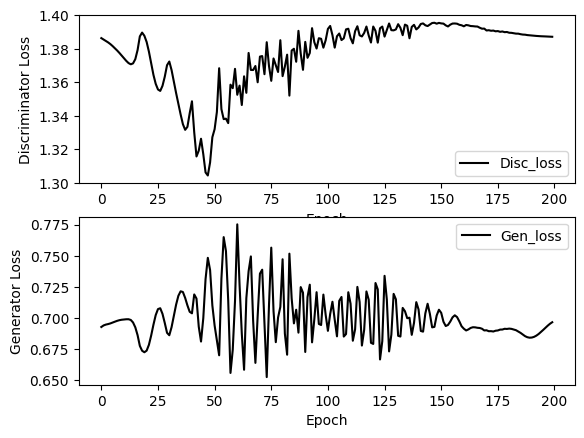

train RMSE:  0.8924912189419458
train MAPE:  0.018101109190137094


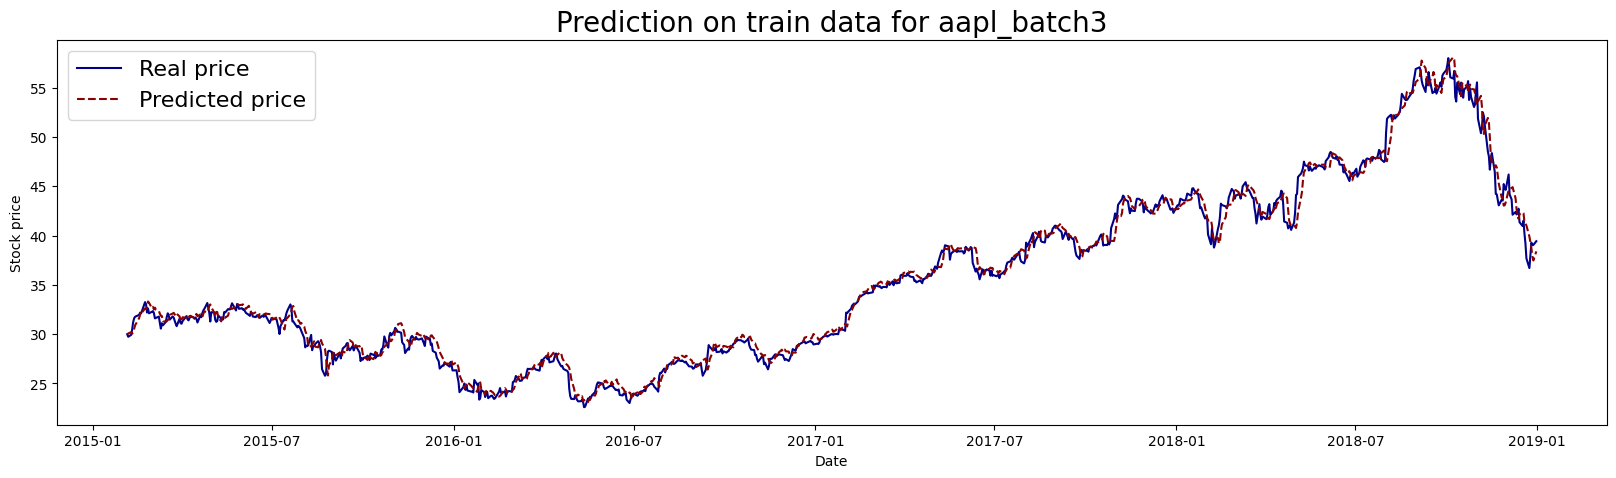

test RMSE:  1.1662544615324044
test MAPE:  0.01764175912994415


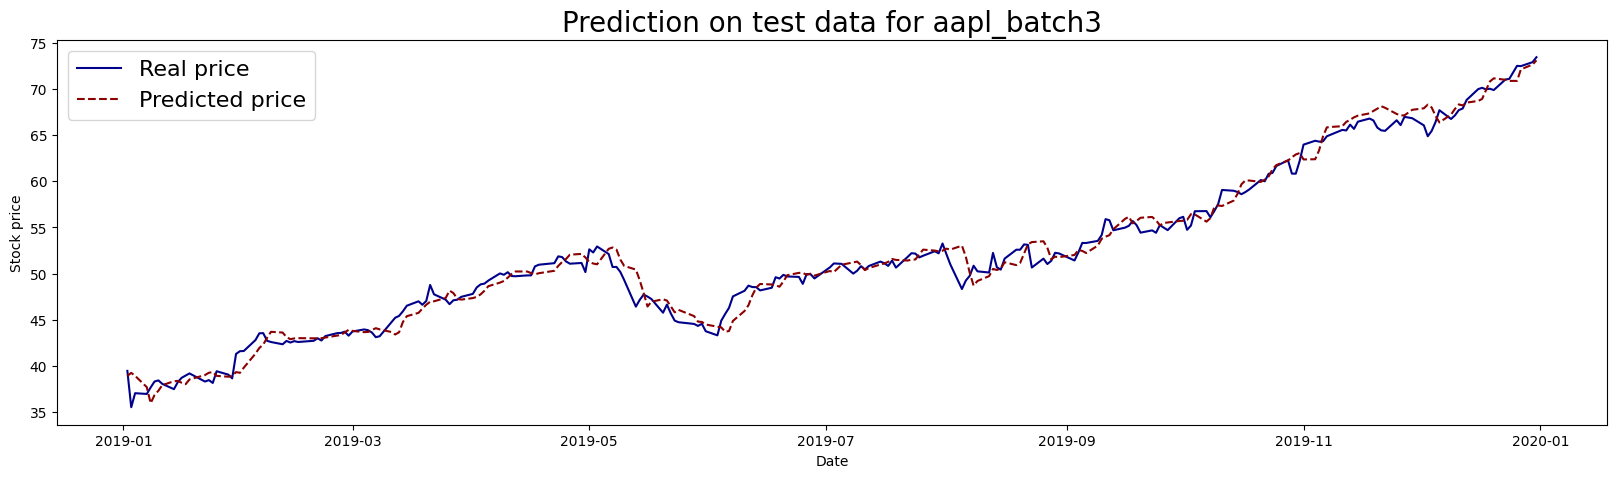

/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/numpy/lib/format.py:368: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


In [29]:
model.prep_data_run_model('aapl_batch3', 'aapl', sa_aapl, learning_rate, epochs, batch_size=3, predict_period=1, SA_indicator=1)

X shape: (1235, 3, 12)
y shape: (1235, 1)
yc shape: (1235, 3, 1)


  0%|                                                   | 0/200 [00:00<?, ?it/s]/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
 25%|██████████▌                               | 50/200 [01:06<02:31,  1.01s/it]

epoch 50 discriminator_loss 1.3089509 generator_loss 0.7136457


 50%|████████████████████▌                    | 100/200 [01:58<01:55,  1.15s/it]

epoch 100 discriminator_loss 1.3886766 generator_loss 0.68961227


 75%|██████████████████████████████▊          | 150/200 [02:47<00:51,  1.03s/it]

epoch 150 discriminator_loss 1.391374 generator_loss 0.6906831


100%|█████████████████████████████████████████| 200/200 [03:42<00:00,  1.11s/it]

epoch 200 discriminator_loss 1.3881855 generator_loss 0.69266653


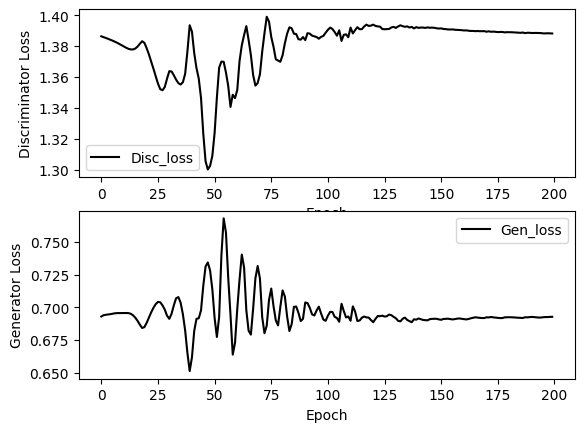

train RMSE:  0.9736837350559758
train MAPE:  0.016274489945827194


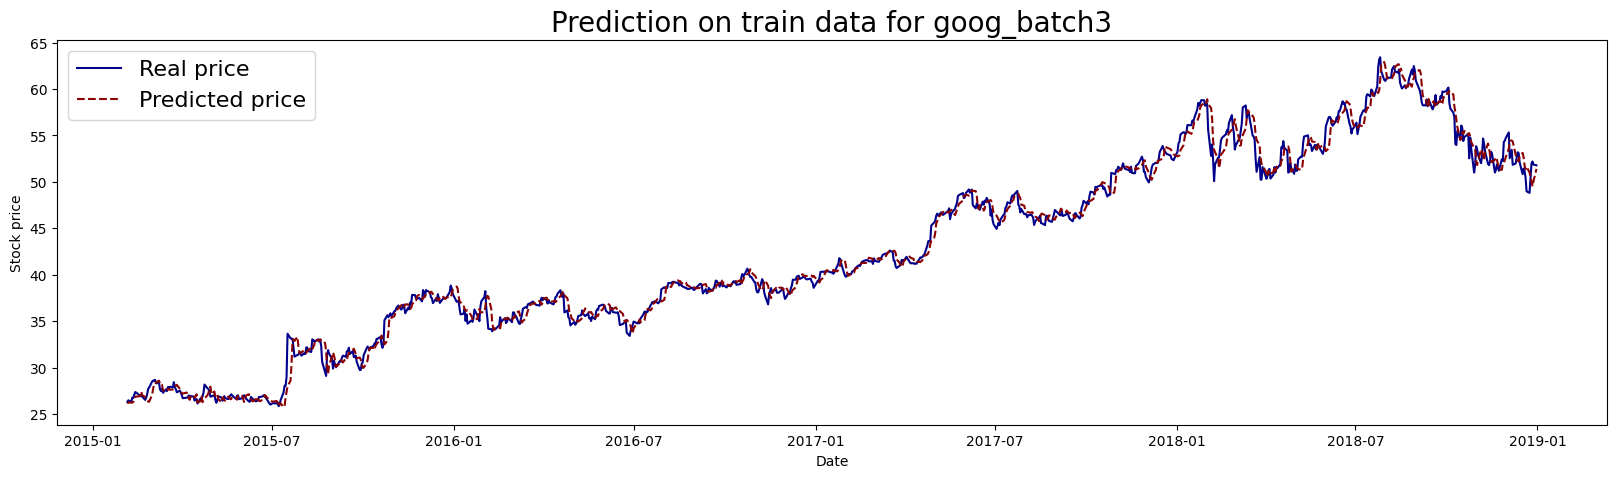

test RMSE:  1.2435143863422846
test MAPE:  0.016056051105782086


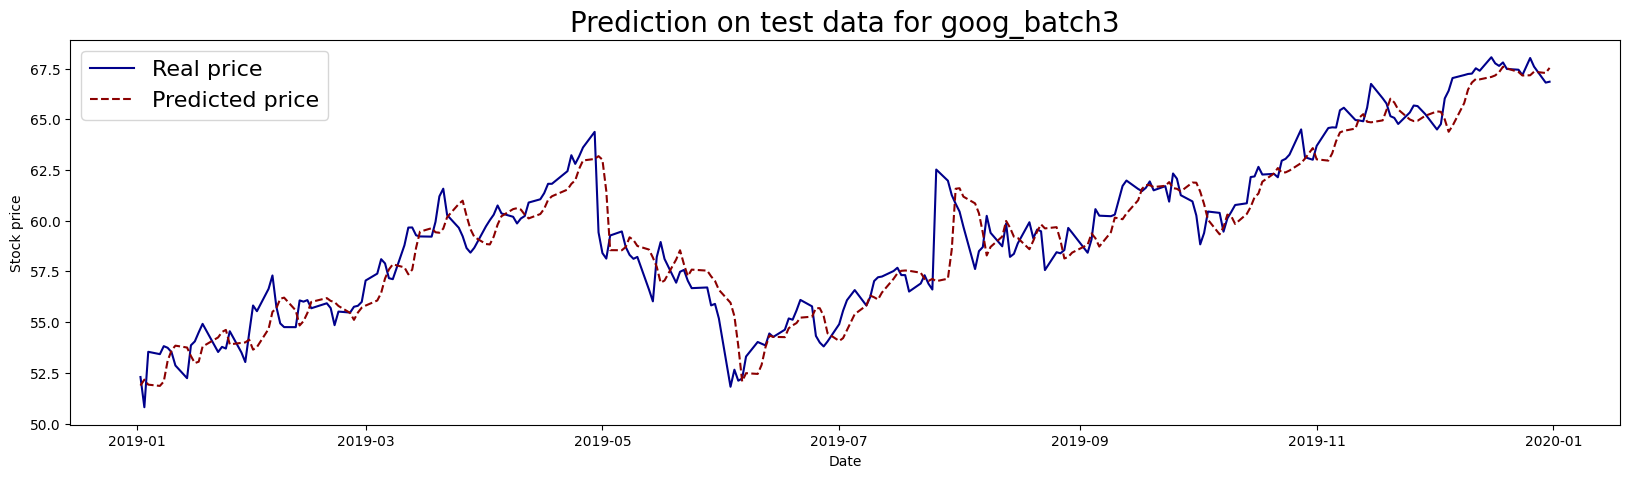

/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/numpy/lib/format.py:368: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


In [5]:
model.prep_data_run_model('goog_batch3', 'goog', sa_goog, learning_rate, epochs, batch_size=3, predict_period=1, SA_indicator=1)

X shape: (1235, 3, 12)
y shape: (1235, 1)
yc shape: (1235, 3, 1)


  0%|                                                   | 0/250 [00:00<?, ?it/s]/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
 20%|████████▍                                 | 50/250 [01:09<04:01,  1.21s/it]

epoch 50 discriminator_loss 1.3153791 generator_loss 0.7011482


 40%|████████████████▍                        | 100/250 [02:08<02:55,  1.17s/it]

epoch 100 discriminator_loss 1.379631 generator_loss 0.7660451


 60%|████████████████████████▌                | 150/250 [03:11<02:21,  1.42s/it]

epoch 150 discriminator_loss 1.3917074 generator_loss 0.70242554


 80%|████████████████████████████████▊        | 200/250 [04:17<01:04,  1.28s/it]

epoch 200 discriminator_loss 1.391654 generator_loss 0.69513094


100%|█████████████████████████████████████████| 250/250 [05:19<00:00,  1.28s/it]

epoch 250 discriminator_loss 1.3877842 generator_loss 0.69154286


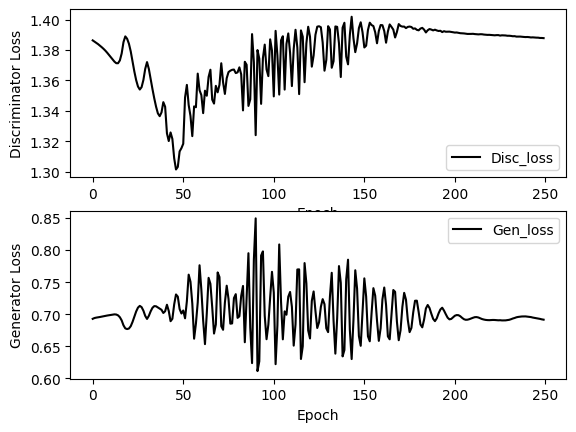

train RMSE:  1.5195427094087472
train MAPE:  0.01565585533279902


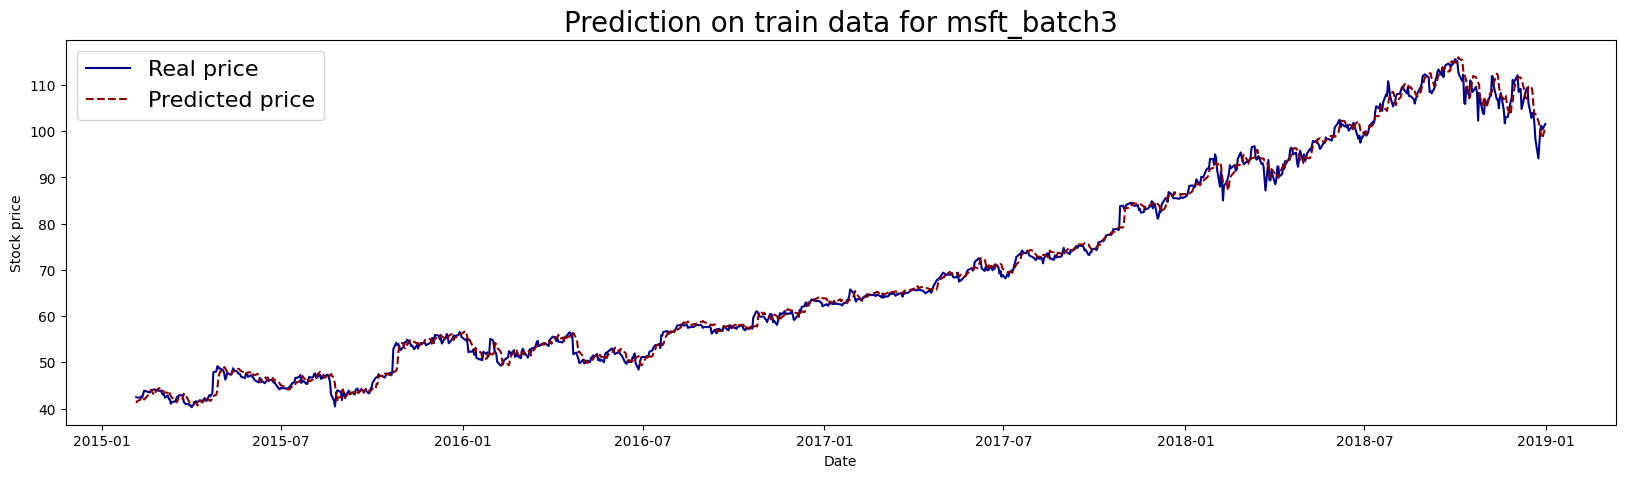

test RMSE:  2.3756169376930907
test MAPE:  0.014264113051099432


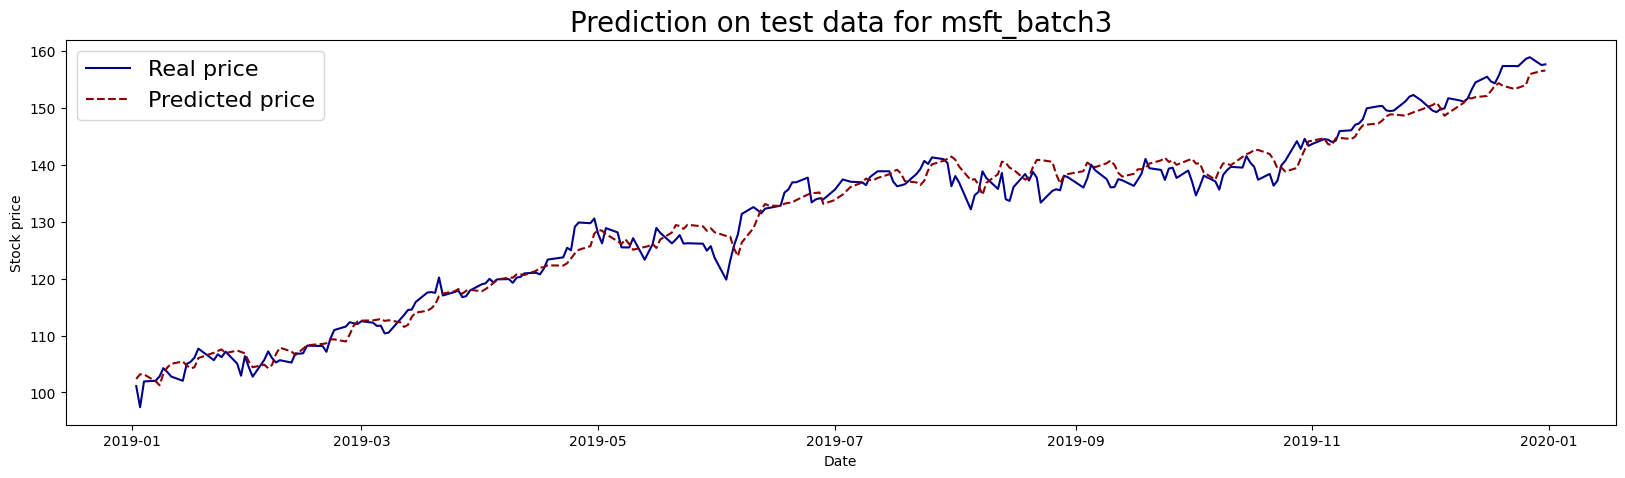

/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/numpy/lib/format.py:368: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


In [6]:
model.prep_data_run_model('msft_batch3', 'msft', sa_msft, learning_rate, epochs, batch_size=3, predict_period=1, SA_indicator=1) #learning_rate = 250

### MODEL WITHOUT SENTIMENT ANALYSIS

X shape: (1232, 3, 12)
y shape: (1232, 1)
yc shape: (1232, 3, 1)
No SA, X train: (980, 3, 11)
No SA, X test: (252, 3, 11)


  0%|                                                   | 0/200 [00:00<?, ?it/s]/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
 25%|██████████▌                               | 50/200 [01:09<02:33,  1.02s/it]

epoch 50 discriminator_loss 1.3234509 generator_loss 0.72744703


 50%|████████████████████▌                    | 100/200 [01:59<01:43,  1.03s/it]

epoch 100 discriminator_loss 1.385756 generator_loss 0.73022777


 75%|██████████████████████████████▊          | 150/200 [02:48<00:51,  1.02s/it]

epoch 150 discriminator_loss 1.3944055 generator_loss 0.7091392


100%|█████████████████████████████████████████| 200/200 [03:38<00:00,  1.09s/it]

epoch 200 discriminator_loss 1.3873249 generator_loss 0.6988002


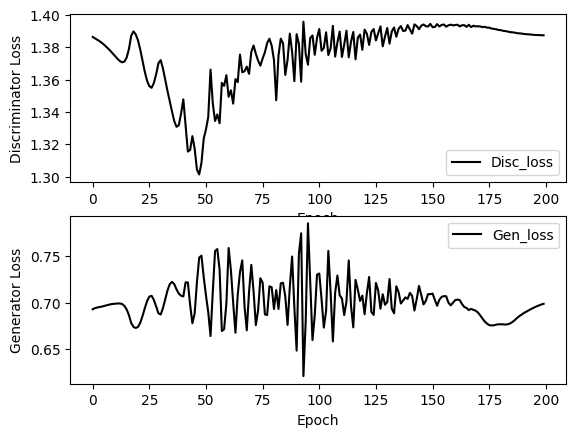

train RMSE:  0.9007403532903377
train MAPE:  0.01747040432421834


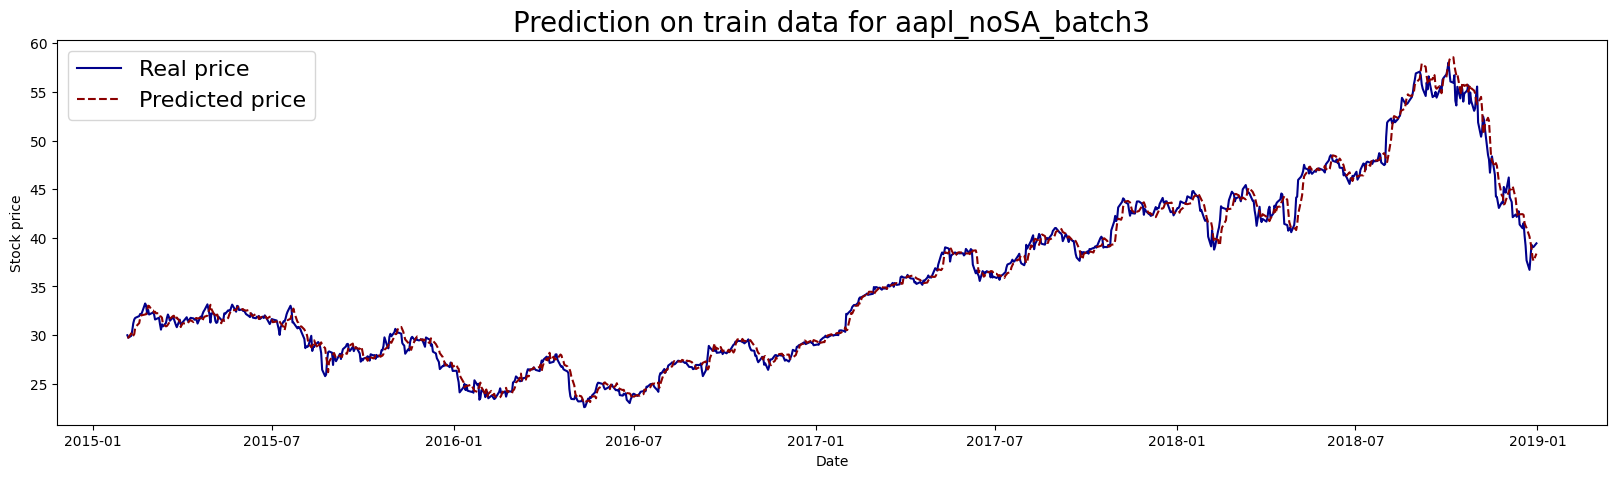

test RMSE:  1.4886209365506724
test MAPE:  0.021102017043777992


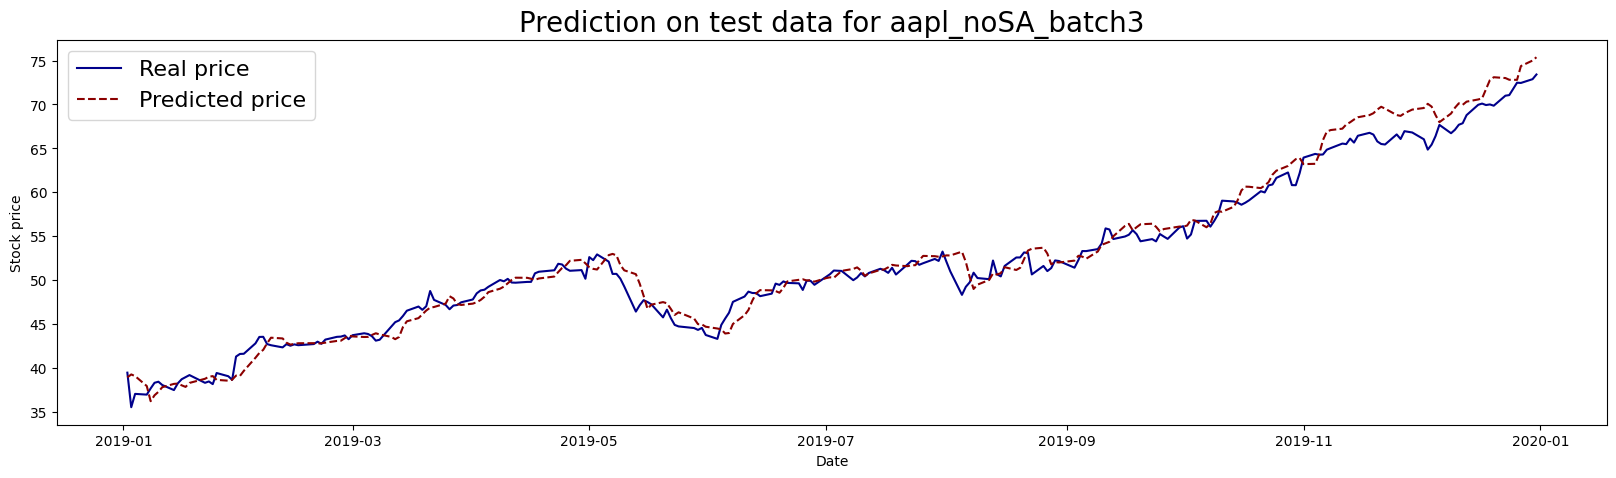

/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/numpy/lib/format.py:368: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


In [5]:
model.prep_data_run_model('aapl_noSA_batch3', 'aapl', sa_aapl, learning_rate, epochs, batch_size=3, predict_period=1, SA_indicator=0)

X shape: (1235, 3, 12)
y shape: (1235, 1)
yc shape: (1235, 3, 1)
No SA, X train: (983, 3, 11)
No SA, X test: (252, 3, 11)


  0%|                                                   | 0/200 [00:00<?, ?it/s]/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
 25%|██████████▌                               | 50/200 [01:08<02:42,  1.08s/it]

epoch 50 discriminator_loss 1.3096685 generator_loss 0.71884406


 50%|████████████████████▌                    | 100/200 [01:59<01:45,  1.06s/it]

epoch 100 discriminator_loss 1.3885252 generator_loss 0.68516093


 75%|██████████████████████████████▊          | 150/200 [02:49<00:52,  1.05s/it]

epoch 150 discriminator_loss 1.3881814 generator_loss 0.69145155


100%|█████████████████████████████████████████| 200/200 [03:39<00:00,  1.10s/it]

epoch 200 discriminator_loss 1.3854673 generator_loss 0.69382375


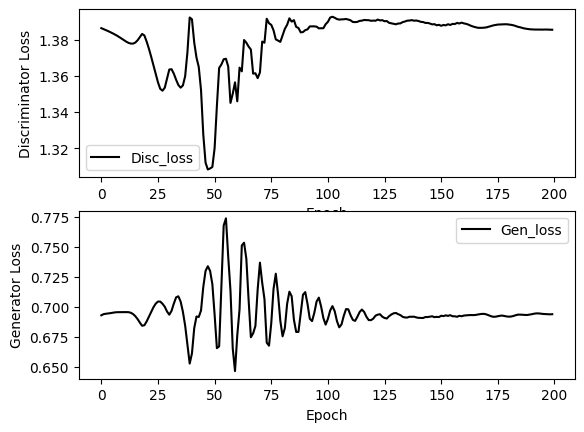

train RMSE:  1.345646661777431
train MAPE:  0.02447993339002453


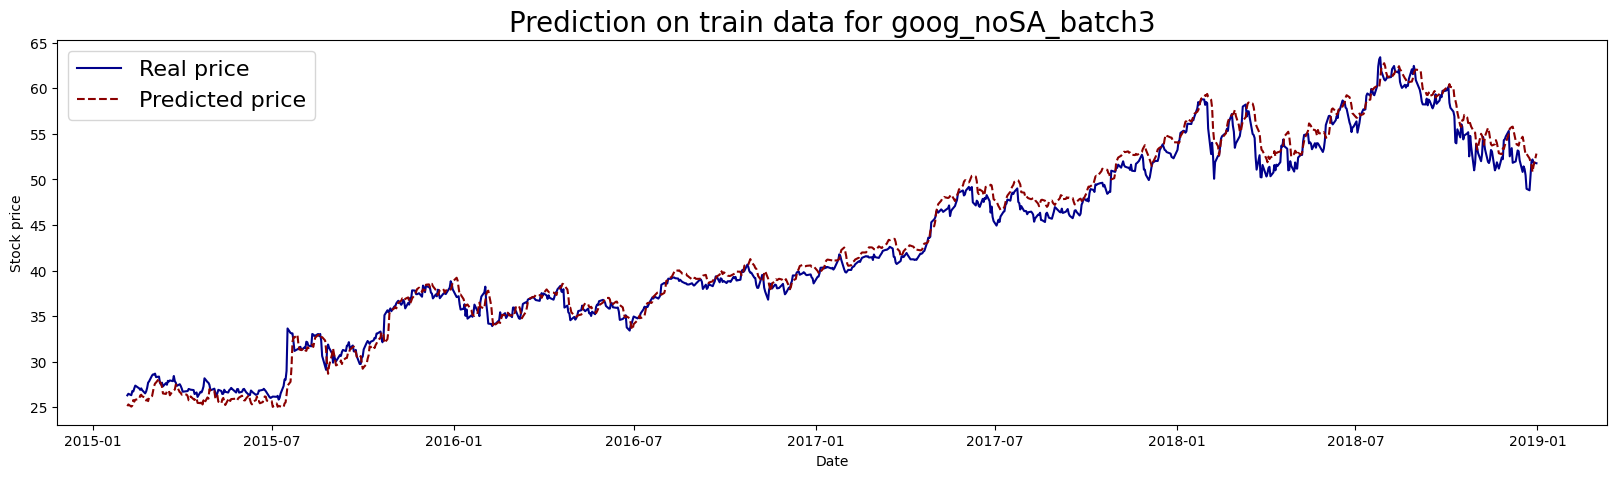

test RMSE:  1.5442509554201356
test MAPE:  0.01995050455728757


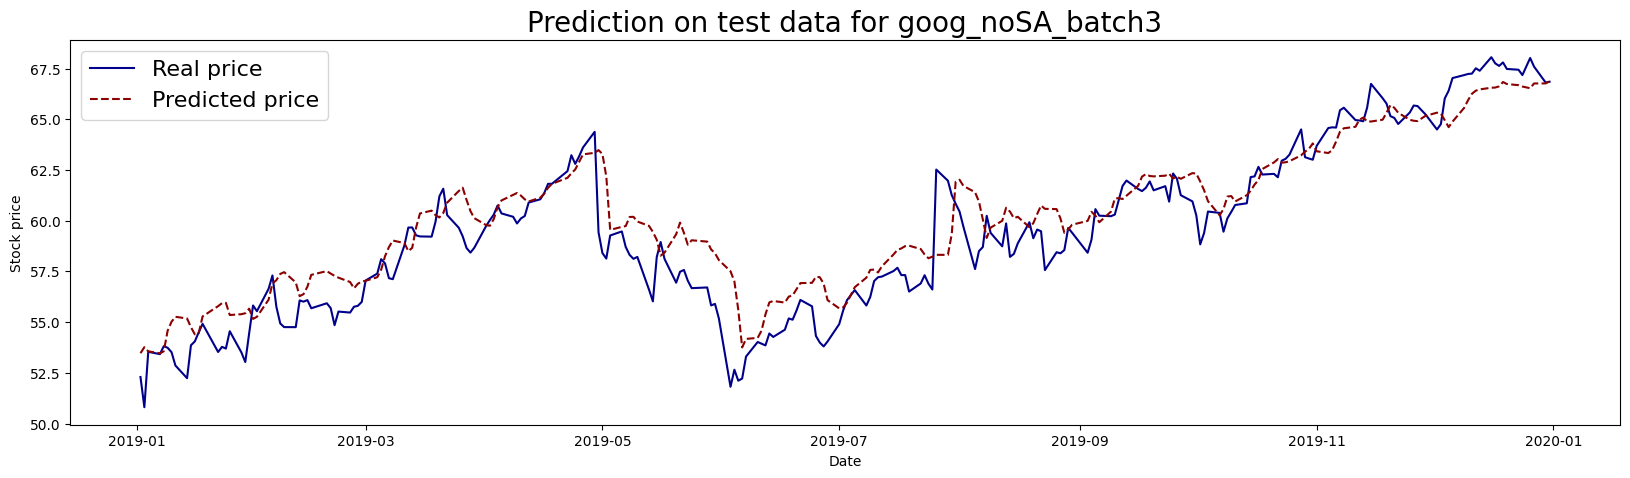

/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/numpy/lib/format.py:368: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


In [5]:
model.prep_data_run_model('goog_noSA_batch3', 'goog', sa_goog, learning_rate, epochs, batch_size=3, predict_period=1, SA_indicator=0)

X shape: (1235, 3, 12)
y shape: (1235, 1)
yc shape: (1235, 3, 1)
No SA, X train: (983, 3, 11)
No SA, X test: (252, 3, 11)


  0%|                                                   | 0/250 [00:00<?, ?it/s]/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
 20%|████████▍                                 | 50/250 [01:12<03:51,  1.16s/it]

epoch 50 discriminator_loss 1.2988498 generator_loss 0.70588106


 40%|████████████████▍                        | 100/250 [02:11<03:14,  1.30s/it]

epoch 100 discriminator_loss 1.3581975 generator_loss 0.6841141


 60%|████████████████████████▌                | 150/250 [03:18<02:19,  1.40s/it]

epoch 150 discriminator_loss 1.3882822 generator_loss 0.7222041


 80%|████████████████████████████████▊        | 200/250 [04:18<00:58,  1.17s/it]

epoch 200 discriminator_loss 1.3906348 generator_loss 0.6983403


100%|█████████████████████████████████████████| 250/250 [05:19<00:00,  1.28s/it]

epoch 250 discriminator_loss 1.3877888 generator_loss 0.69432783


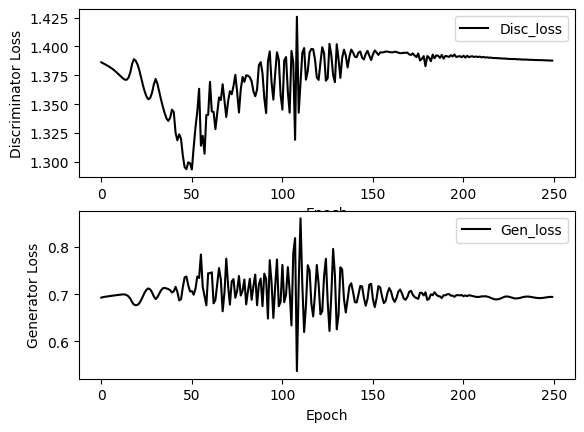

train RMSE:  1.5216445606330593
train MAPE:  0.015278044612817041


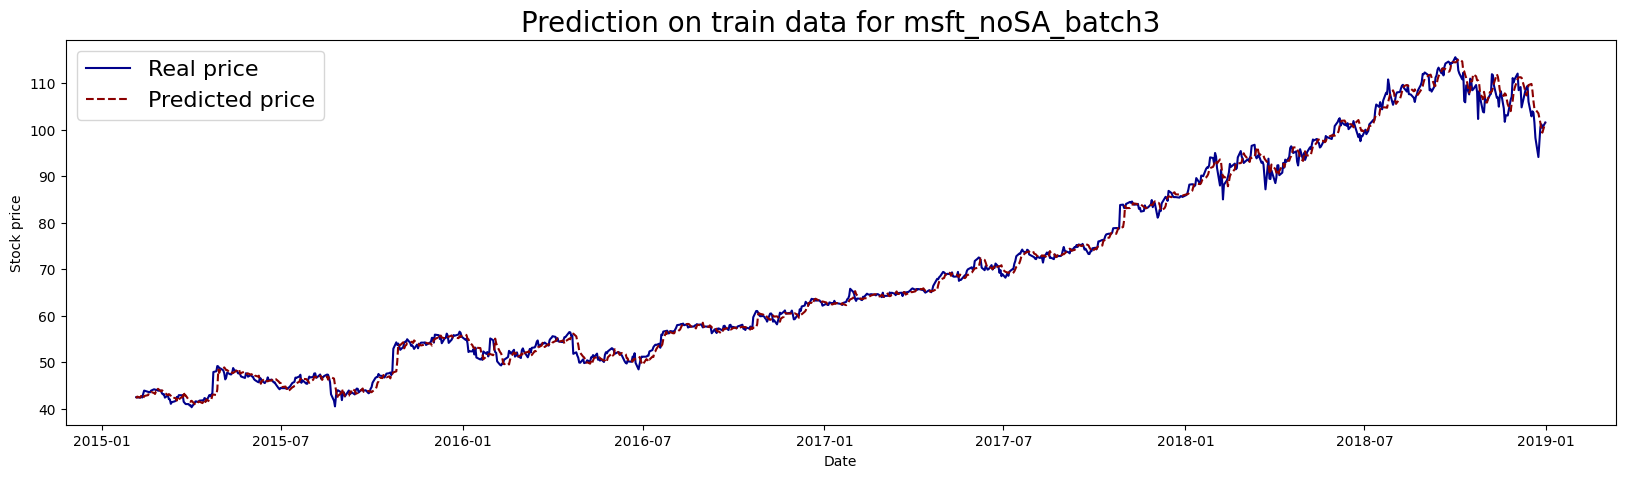

test RMSE:  3.0609222537583984
test MAPE:  0.01832433611232299


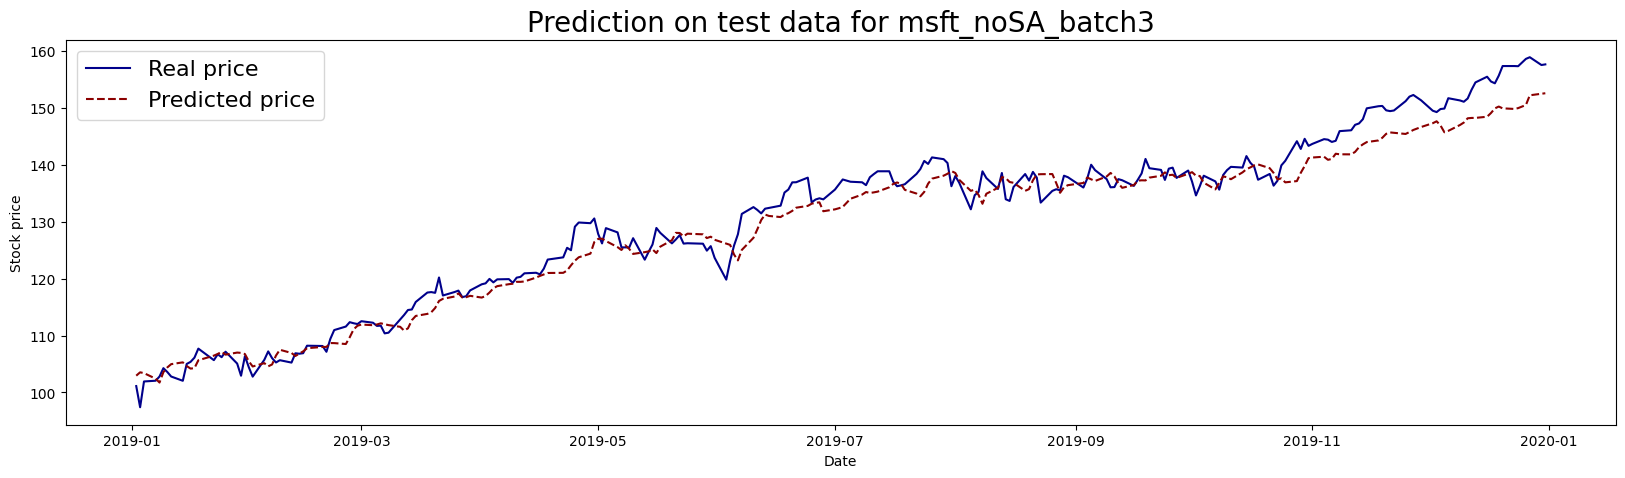

/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/numpy/lib/format.py:368: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


In [6]:
model.prep_data_run_model('msft_noSA_batch3', 'msft', sa_msft, learning_rate, epochs, batch_size=3, predict_period=1, SA_indicator=0)